## Import Packages

In [ ]:
!pip install pykeops > install.log

In [ ]:
%matplotlib inline
import pykeops

In [ ]:
pykeops.test_numpy_bindings()
pykeops.test_torch_bindings()

pyKeOps with numpy bindings is working!
pyKeOps with torch bindings is working!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.preprocessing import normalize
from skimage.util import random_noise

## Load Data

(160, 228)


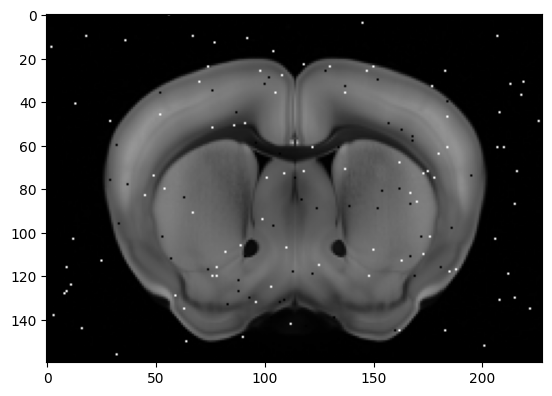

(160, 228)

In [ ]:
I = cv2.imread("/content/brain.tif",cv2.IMREAD_UNCHANGED) # Please change the file directory to where your input image is.
I = random_noise(I, mode='s&p',amount=0.005)

print(I.shape)
plt.imshow(I,cmap="Greys_r")
plt.show()
h,w = I.shape
h,w

## Get target variables pT, mT, gT (normalized)

In [ ]:
x, y = np.mgrid[0:w, 0:h]

dx, dy = np.gradient(I)

threshold_grad = 0.05
quiver_length = np.sqrt(np.add(np.multiply(dx,dx),np.multiply(dy,dy))) # array of gradient norm

index_qui = (np.argwhere(quiver_length>threshold_grad)) # index of remaining quivers
pT = index_qui # position of the points
print(pT.shape)

mT = np.ones((pT.shape[0],1))
print(mT.shape)

gT = np.transpose(np.array([dx[pT[:,0], pT[:,1]], dy[pT[:,0], pT[:,1]]])) # gradients of these points
gT = normalize(gT, axis=1) # normalize the gradients
gT = np.matmul(gT, np.array([[0,-1],[1,0]])) # rotate 90 degrees

pT=np.transpose(np.array([pT[:,1],pT[:,0]])) # Swap left and right columns of pT
gT=np.transpose(np.array([gT[:,1],gT[:,0]])) # Swap left and right columns of gT

print(gT)
print(gT.shape)

(2626, 2)
(2626, 1)
[[ 0.  1.]
 [ 1.  0.]
 [ 0. -1.]
 ...
 [ 0.  1.]
 [ 0. -1.]
 [ 1.  0.]]
(2626, 2)


## Get Center of Object and Create the Ellipse

In [ ]:
cx,cy=np.mean(pT,0)
print(cx)
print(cy)

bx=1.7*np.sqrt(np.var(pT[:,0]))
print(bx)

by=1.7*np.sqrt(np.var(pT[:,1]))
print(by)

114.77151561309977
82.48248286367098
91.82828167889188
67.71533466258636


In [ ]:
# Create the semi-ellipse
N=200
t=np.linspace(0,2*np.pi*(1-1/N),N)

xe=cx+bx*np.cos(t)*0.9    # points on the ellipse
ye=cy+by*np.sin(t)*0.9

VS=np.zeros((N,2))    # VS is the array of the vertices on the ellipse, which is Nx2
VS[:,0]=xe
VS[:,1]=ye

FS=np.zeros((N,2),int) # FS is the face matrix of the source shape
FS[:,0]=np.array([i for i in range(0,N)])
FS[:,1]=np.append(np.array([i for i in range(1,N)]),0)

V0, V1 = (
            VS[FS[:, 0],],
            VS[FS[:, 1],],
        )
length = np.sqrt(np.sum((V1-V0)**2,1))
tot_length=np.sum(length)

mT=mT*tot_length/pT.shape[0]
np.sum(mT)

np.float64(453.66003562496974)

## Plot the Gradient Field

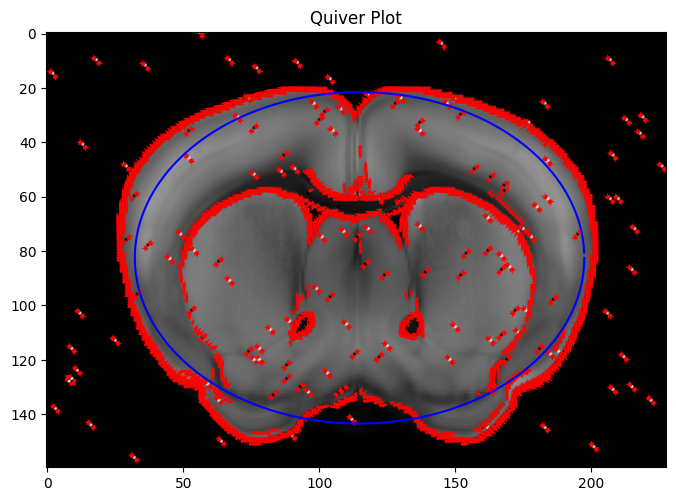

In [ ]:
# Plot the graph with Quiver
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(I,cmap="Greys_r")

ax.quiver(pT[:,0], pT[:,1], gT[:,0], gT[:,1],color='r')

ax.set_title('Quiver Plot')

# Plot the ellipse on the graph
ax.plot(xe,ye,color='b')

plt.show()

## Registration



Load the dataset and plot it



In [ ]:
sigmaV = torch.tensor([10.], dtype=torchdtype, device=torchdeviceId)
sigmaW = torch.tensor([5.], dtype=torchdtype, device=torchdeviceId)
gamma = torch.tensor([0.5], dtype=torchdtype, device=torchdeviceId)

q0 = torch.tensor(VS).to(dtype=torchdtype, device=torchdeviceId).requires_grad_(True)
FS = torch.tensor(FS).to(dtype=torch.long, device=torchdeviceId)
pT= torch.tensor(pT).to(dtype=torchdtype, device=torchdeviceId)
gT= torch.tensor(gT).to(dtype=torchdtype, device=torchdeviceId)
mT = torch.tensor(mT).to(dtype=torchdtype, device=torchdeviceId)

Define data attachment and LDDMM functional



In [ ]:
dataloss = lossVarifoldSurfWeight(FS, pT, gT, mT, GaussLinKernel(sigma=sigmaW))
Kv = GaussKernel(sigma=sigmaV)
loss = LDDMMloss(Kv, dataloss, gamma)

[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.


Perform optimization



In [ ]:
# initialize momentum vectors
p0 = torch.zeros(q0.shape, dtype=torchdtype, device=torchdeviceId, requires_grad=True)

optimizer = torch.optim.Adam([p0],lr=0.1)
print("performing optimization...")
start = time.time()


def closure():
    optimizer.zero_grad()
    L = loss(p0, q0)
    print("loss", L.detach().cpu().numpy())
    L.backward()
    return L


for i in range(300):
    print("it ", i, ": ", end="")
    optimizer.step(closure)

print("Optimization (L-BFGS) time: ", round(time.time() - start, 2), " seconds")

performing optimization...
it  0 : [pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
loss [1169.5693]
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
it  1 : [pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
loss [1116.8323]
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
it  2 : [pyKeOps] Warning : at least one of the input tensors is not contiguous. Co

## Display Output



In [ ]:
nt = 10
p,q = Shooting(p0, q0, Kv, nt=nt)[-1]

q = q.detach().cpu().numpy()
x=q[:, 0],
y=q[:, 1],
xd=np.asarray(x)[0]
yd=np.asarray(y)[0]

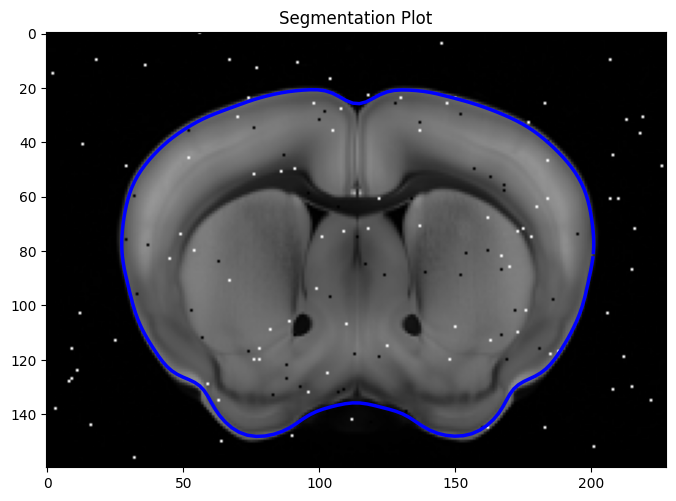

In [ ]:
# Plot the graph with Quiver
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(I,cmap="Greys_r")

ax.set_title('Segmentation Plot')

# Plot the ellipse on the graph
ax.plot(xd,yd,color='b', linewidth=2.5)

plt.show()